# Group Segmentation
We will now combine everything we have learned from dimensionality reduction, anomaly detection, and clustering to tackle real-life unsupervised learning problems. 

Group segmentation could improve targeting in online advertising and improve recommendations in recommender system for movies, music, news, social networking, dating, etc. 

In [3]:
!ls datasets/lending_club_data/

LCDataDictionary.xlsx LoanStats3a.csv


In [1]:
# importing libraries
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist

## Loading Data

In [5]:
# loading data
file = './datasets/lending_club_data/LoanStats3a.csv'
data = pd.read_csv(file)

In [6]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
columns_to_keep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

# cleaning our data
data = data.loc[:,columns_to_keep]
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,10+ years,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,< 1 year,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,10+ years,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,10+ years,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,1 year,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


## Transforming String format to Numerical format
we need to convert a few string formatted featured into numerical representations for our machine learning algorithms

In [8]:
# transform features from string to numeric
for i in ['term', 'int_rate', 'emp_length', 'revol_util']:
    data.loc[:,i] = data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

In [9]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,4975.0,36.0,1065.0,162.87,B,B2,10.0,RENT,...,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-15,171.62
1,2500.0,2500.0,2500.0,60.0,1527.0,59.83,C,C4,1.0,RENT,...,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-13,119.66
2,2400.0,2400.0,2400.0,36.0,1596.0,84.33,C,C5,10.0,RENT,...,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-14,649.91
3,10000.0,10000.0,10000.0,36.0,1349.0,339.31,C,C1,10.0,RENT,...,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-15,357.48
4,3000.0,3000.0,3000.0,60.0,1269.0,67.79,B,B5,1.0,RENT,...,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-17,67.30


## Checking NaN Values

In [10]:
# are we missing any features? - nan?

# numerical features
numerical_features = [x for x in data.columns if data[x].dtype != 'object']
data[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42542 entries, 0 to 42541
Data columns (total 27 columns):
loan_amnt                  42535 non-null float64
funded_amnt                42535 non-null float64
funded_amnt_inv            42535 non-null float64
term                       42535 non-null float64
int_rate                   42535 non-null float64
installment                42535 non-null float64
emp_length                 41423 non-null float64
annual_inc                 42531 non-null float64
dti                        42535 non-null float64
delinq_2yrs                42506 non-null float64
mths_since_last_delinq     15609 non-null float64
mths_since_last_record     3651 non-null float64
open_acc                   42506 non-null float64
pub_rec                    42506 non-null float64
revol_bal                  42535 non-null float64
revol_util                 42445 non-null float64
total_acc                  42506 non-null float64
out_prncp                  42535 non-null 

In [11]:
np.isnan(data.loc[:,numerical_features]).sum()

loan_amnt                      7
funded_amnt                    7
funded_amnt_inv                7
term                           7
int_rate                       7
installment                    7
emp_length                  1119
annual_inc                    11
dti                            7
delinq_2yrs                   36
mths_since_last_delinq     26933
mths_since_last_record     38891
open_acc                      36
pub_rec                       36
revol_bal                      7
revol_util                    97
total_acc                     36
out_prncp                      7
out_prncp_inv                  7
total_pymnt                    7
total_pymnt_inv                7
total_rec_prncp                7
total_rec_int                  7
total_rec_late_fee             7
recoveries                     7
collection_recovery_fee        7
last_pymnt_amnt                7
dtype: int64

In [12]:
# imputing columns with mean
fill_with_mean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fill_with_zero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

In [15]:
im = pp.Imputer(strategy="mean")

data.loc[:,fill_with_mean] = im.fit_transform(data[fill_with_mean])
data.loc[:,fill_with_zero] = data.loc[:,fill_with_zero].fillna(value=0,axis=1)

/Users/diegomedina-bernal/miniconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
numerical_features = [x for x in data.columns if data[x].dtype != 'object']
np.isnan(data.loc[:,numerical_features]).sum()

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

## Feature Engineering

In [17]:
# Feature engineering
data['installment_over_loan_amnt'] = data['installment']/data['loan_amnt']
data['loan_amnt_over_income'] = data['loan_amnt']/data['annual_inc']
data['revol_bal_over_income'] = data['revol_bal']/data['annual_inc']
data['total_payment_over_income'] = data['total_pymnt']/data['annual_inc']
data['total_payment_inv_over_income'] = data['total_pymnt_inv']/data['annual_inc']
data['total_rec_prnc_over_income'] = data['total_rec_prncp']/data['annual_inc']
data['total_rec_int_over_income'] = data['total_rec_int']/data['annual_inc']

new_features = ['installment_over_loan_amnt', 'loan_amnt_over_income', 'revol_bal_over_income', 'total_payment_over_income', 'total_payment_inv_over_income', 'total_rec_prnc_over_income', 'total_rec_int_over_income']

In [18]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,installment_over_loan_amnt,loan_amnt_over_income,revol_bal_over_income,total_payment_over_income,total_payment_inv_over_income,total_rec_prnc_over_income,total_rec_int_over_income
0,5000.0,5000.0,4975.0,36.0,1065.0,162.87,B,B2,10.0,RENT,...,0.00,Jan-15,171.62,0.032574,0.208333,0.568667,0.244298,0.243077,0.208333,0.035965
1,2500.0,2500.0,2500.0,60.0,1527.0,59.83,C,C4,1.0,RENT,...,1.11,Apr-13,119.66,0.023932,0.083333,0.056233,0.033818,0.033818,0.015215,0.014506
2,2400.0,2400.0,2400.0,36.0,1596.0,84.33,C,C5,10.0,RENT,...,0.00,Jun-14,649.91,0.035138,0.195886,0.241267,0.245321,0.245321,0.195886,0.049434
3,10000.0,10000.0,10000.0,36.0,1349.0,339.31,C,C1,10.0,RENT,...,0.00,Jan-15,357.48,0.033931,0.203252,0.113780,0.248616,0.248616,0.203252,0.045019
4,3000.0,3000.0,3000.0,60.0,1269.0,67.79,B,B5,1.0,RENT,...,0.00,Jan-17,67.30,0.022597,0.037500,0.347288,0.050836,0.050836,0.037500,0.013336


## Selecting Final Set of Features and Performing Scaling

In [19]:
# Only using numerical features for our training
numerical_plus_new_features = numerical_features + new_features

X_train = data.loc[:,numerical_plus_new_features]

In [20]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,...,recoveries,collection_recovery_fee,last_pymnt_amnt,installment_over_loan_amnt,loan_amnt_over_income,revol_bal_over_income,total_payment_over_income,total_payment_inv_over_income,total_rec_prnc_over_income,total_rec_int_over_income
0,5000.0,5000.0,4975.0,36.0,1065.0,162.87,10.0,24000.0,27.65,0.0,...,0.0,0.00,171.62,0.032574,0.208333,0.568667,0.244298,0.243077,0.208333,0.035965
1,2500.0,2500.0,2500.0,60.0,1527.0,59.83,1.0,30000.0,1.00,0.0,...,122.9,1.11,119.66,0.023932,0.083333,0.056233,0.033818,0.033818,0.015215,0.014506
2,2400.0,2400.0,2400.0,36.0,1596.0,84.33,10.0,12252.0,8.72,0.0,...,0.0,0.00,649.91,0.035138,0.195886,0.241267,0.245321,0.245321,0.195886,0.049434
3,10000.0,10000.0,10000.0,36.0,1349.0,339.31,10.0,49200.0,20.00,0.0,...,0.0,0.00,357.48,0.033931,0.203252,0.113780,0.248616,0.248616,0.203252,0.045019
4,3000.0,3000.0,3000.0,60.0,1269.0,67.79,1.0,80000.0,17.94,0.0,...,0.0,0.00,67.30,0.022597,0.037500,0.347288,0.050836,0.050836,0.037500,0.013336


In [21]:
# Scaling data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [22]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,...,recoveries,collection_recovery_fee,last_pymnt_amnt,installment_over_loan_amnt,loan_amnt_over_income,revol_bal_over_income,total_payment_over_income,total_payment_inv_over_income,total_rec_prnc_over_income,total_rec_int_over_income
0,-0.821798,-0.814636,-0.724301,-0.590694,-0.408626,-0.764707,1.471829,-0.704298,2.122752,-0.297382,...,-0.139866,-0.088594,-0.556857,0.496911,0.191382,1.663367,0.318077,0.398856,0.418444,-0.013688
1,-1.159169,-1.164470,-1.071381,1.693204,0.837468,-1.257939,-1.201679,-0.610676,-1.839671,-0.297382,...,0.027213,-0.081748,-0.568707,-1.251238,-0.884205,-0.714896,-1.188170,-1.107276,-1.309053,-0.578048
2,-1.172664,-1.178463,-1.085404,-0.590694,1.023573,-1.140663,1.471829,-0.887610,-0.691832,-0.297382,...,-0.139866,-0.088594,-0.447774,1.015469,0.084280,0.143866,0.325393,0.415007,0.307102,0.340544
3,-0.147056,-0.114968,-0.019624,-0.590694,0.357371,0.079877,1.471829,-0.311084,0.985321,-0.297382,...,-0.139866,-0.088594,-0.514468,0.771412,0.147659,-0.447813,0.348974,0.438722,0.372990,0.224416
4,-1.091695,-1.094503,-1.001264,1.693204,0.141597,-1.219836,-1.201679,0.169510,0.679032,-0.297382,...,-0.139866,-0.088594,-0.580649,-1.521356,-1.278586,0.635921,-1.066380,-0.984785,-1.109710,-0.608799


## Designing Labels for Evaluation
Given we don't have labeled data, we must come up with a mechaniscm to help score our unsupervised approach. 

We will use the loan grade as a proxy label. 

In [23]:
labels = data['grade']
labels.unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [24]:
# Replace NaN with Z
labels = labels.fillna(value="Z")

# Encode our labels - transform to numerical feature
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))

labels = pd.Series(data=lbl.transform(labels.values), name='grade')

In [25]:
labels.unique()

array([1, 2, 0, 4, 5, 3, 6, 7])

In [26]:
# store our y_train
y_train = labels

# forming a dataframe to show map
labels_original_vs_new = pd.concat([labels, data.grade], axis=1)
labels_original_vs_new.head()

,grade,grade
0,1,B
1,2,C
2,2,C
3,2,C
4,1,B


# Algorithms
Now our data is ready and we are ready to feed it into our machine learning pipeline. 

Before testing different algorithms, we will create a function to analyze our cluster

In [27]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = \
        pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True,drop=False)
    countByCluster.columns = ['cluster','clusterCount']
        
    preds = pd.concat([labelsDF,clusterDF], axis=1)
    preds.columns = ['trueLabel','cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
        
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg( \
        lambda x:x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True,drop=False)
    countMostFreq.columns = ['cluster','countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, \
        left_on="cluster",right_on="cluster")
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/ \
        accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/ \
        accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, \
        accuracyDF, overallAccuracy, accuracyByLabel

# k-Means Application


In [28]:
from sklearn.cluster import KMeans

In [29]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 2018
n_jobs = 2

In [32]:
# We will be testing different cluster sizes
kmeans_inertia = pd.DataFrame(data=[], index=range(10,31), columns=['intertia'])

# Keeping score of our accuracy for each trail
overall_accuracy_kmeans_DF = pd.DataFrame(data=[], index=range(10,31), columns=['overall_accuracy'])

for n_clusters in range(10, 31):
    kmeans = KMeans(n_clusters=n_clusters,n_init=n_init,max_iter=max_iter,tol=tol,random_state=random_state,n_jobs=n_jobs)
    
    kmeans.fit(X_train)
    
    kmeans_inertia.loc[n_clusters] = kmeans.inertia_
    
    X_train_kmeans_clustered = kmeans.predict(X_train)
    X_train_kmeans_clustered = pd.DataFrame(data=X_train_kmeans_clustered, index=X_train.index, columns=['cluster'])
    
    counter_by_cluster_kmeans, count_by_label_kmeans, count_most_freq_kmeans, accuracy_DF_kmeans, overall_accuracy_kmeans, accuracy_by_label_kmeans = analyzeCluster(X_train_kmeans_clustered, y_train)
    
    overall_accuracy_kmeans_DF.loc[n_clusters] = overall_accuracy_kmeans

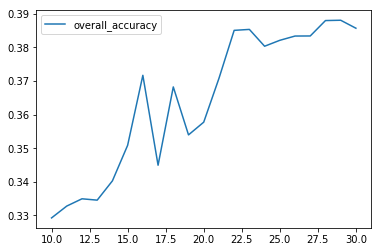

In [33]:
overall_accuracy_kmeans_DF.plot()

For any given cluster, the most-fequent occuring label for that cluster applies to approximately 39% of the borrowers. 

The remaining 61% of the borrowers have labels that are not the most-frequently occurcing. 

# Hierarchical Clustering Application
Let's see if we can perform better with Hierarchical Clustering

In [34]:
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist

In [35]:
Z = fastcluster.linkage_vector(X_train, method='ward', metric='euclidean')

Z_dataframe = pd.DataFrame(data=Z, columns=['cluster_one', 'cluster_two', 'distance', 'new_cluster_size'])

In [36]:
Z_dataframe.head()

,cluster_one,cluster_two,distance,new_cluster_size
0,39786.0,39787.0,0.000000e+00,2.0
1,39788.0,42542.0,0.000000e+00,3.0
2,42538.0,42539.0,0.000000e+00,2.0
3,42540.0,42544.0,0.000000e+00,3.0
4,42541.0,42545.0,3.399350e-17,4.0


In [37]:
Z_dataframe.tail()

,cluster_one,cluster_two,distance,new_cluster_size
42536,85070.0,85077.0,298.587755,16786.0
42537,85058.0,85078.0,309.946867,16875.0
42538,85074.0,85079.0,375.698458,34870.0
42539,85065.0,85080.0,400.711547,37221.0
42540,85076.0,85081.0,644.047472,42542.0


In [38]:
from scipy.cluster.hierarchy import fcluster